In [1]:
import numpy as np
import pandas as pd

In [181]:
dados1 = pd.read_csv('teste1.csv',sep=';',decimal=',')
dados2 = pd.read_csv('teste2.csv',sep=';',decimal=',')

In [182]:
print(dados1.head(4))
print(dados2.head(4))

    Id  prob_treino  prob_resp
0  121          0.1          1
1  112          0.1          1
2   41          0.1          1
3  173          0.1          1
   Id  prob_teste  pred_teste
0   1    0.641170           1
1   2    0.546631           1
2   3    0.239751           1
3   4    0.869883           1


In [183]:
bins

array([ 0.0044222 ,  0.15682701,  0.29195839,  0.50037084,  0.63094502,
        0.81497382,  0.99471668])

In [221]:
def probability_groups (n_groups, train_probs, train_preds, test_probs, test_preds ):
    ser, bins = pd.qcut(train_probs, n_groups, retbins = True)
    print(bins)
    bins2 = bins
    bins2[0] = 0
    bins2[n_groups] = 1
    print(bins2)
    train_table = pd.DataFrame(pd.crosstab(ser, train_preds))
    train_table.columns = ['N_0', 'N_1']
    train_table['total'] = train_table.N_0 + train_table.N_1
    train_table['P_1'] = np.round(train_table['N_1'] / train_table['total'],2)
    train_table['P_total'] = np.round((train_table['total'] / sum(train_table.total) ), 2)
    
    test_group = pd.cut(test_probs, bins=bins, labels=False, include_lowest=True)
    test_table = pd.DataFrame(pd.crosstab(test_group, test_preds))
    test_table.columns = ['N_0', 'N_1']
    test_table['total'] = test_table.N_0 + test_table.N_1
    test_table['P_1'] = np.round(test_table['N_1'] / test_table['total'],2)
    test_table['P_total'] = np.round((test_table['total'] / sum(test_table.total) ), 2)

    
    return (train_table, test_table, test_group)

In [222]:
train_table, test_table, test_group = probability_groups(5, dados1.prob_treino, dados1.prob_resp, dados2.prob_teste, dados2.pred_teste)

[ 0.0044222   0.14170149  0.29932708  0.54332782  0.71912063  0.94410692]
[ 0.          0.14170149  0.29932708  0.54332782  0.71912063  1.        ]


In [223]:
train_table

,N_0,N_1,total,P_1,P_total
prob_treino,,,,,
"(0.00342, 0.142]",18,32,50,0.64,0.2
"(0.142, 0.299]",19,31,50,0.62,0.2
"(0.299, 0.543]",12,38,50,0.76,0.2
"(0.543, 0.719]",15,35,50,0.70,0.2
"(0.719, 0.944]",15,35,50,0.70,0.2


In [224]:
test_table

,N_0,N_1,total,P_1,P_total
prob_teste,,,,,
0,13,15,28,0.54,0.11
1,9,22,31,0.71,0.12
2,25,40,65,0.62,0.26
3,15,41,56,0.73,0.22
4,17,53,70,0.76,0.28


In [225]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plots_prob_groups (train_table, test_table, figsize_1 = 15, figsize_2= 12, fontsize_inside= 16):

    tables = [train_table, test_table]
    fig = plt.figure(figsize=(figsize_1,figsize_2))
    for index, table in enumerate(tables):
        ax = fig.add_subplot(2, 1, index+1)
        #plot
        A = table.P_1
        B = 1- table.P_1
        bar_l = range(len(table.index))
        bar_width = 0.5
        #tick_pos = [i + (bar_width / 2) for i in bar_l]

        ax1 = ax.bar(bar_l, A, width=bar_width,label="A", color="#e87109")
        ax2 = ax.bar(bar_l, B, bottom = A,width=bar_width,label="B", color="#3842f7")
        
        # visual elements
        fontsize_axis = 13
        ax.set_xlabel("Faixas", fontsize=18)
        ax.legend(['Prob_1','Prob_0'],bbox_to_anchor=(1, 0.9),fontsize=fontsize_axis)
        plt.yticks(fontsize=fontsize_axis)
        plt.xticks(fontsize=fontsize_axis)
        ax.set_ylim(0,1.13)
        i = 0

        #plotting texts inside bars
        for r1, r2 in zip(ax1, ax2):
            h1 = np.round(r1.get_height(),decimals=2)
            h2 = np.round(r2.get_height(),decimals=2)
            plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., h1, ha="center", va="center", color="white", fontsize=fontsize_inside, fontweight="bold")
            plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 /2., h2, ha="center", va="center", color="white", fontsize=fontsize_inside, fontweight="bold")
            plt.text(r1.get_x() + r1.get_width() / 2, h1+h2 +0.05, '{:.0%}'.format(np.round(table.P_total[i],2)), ha="center", va="center", color="gray", fontsize=13)
            i += 1

    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    plt.show()
        
       

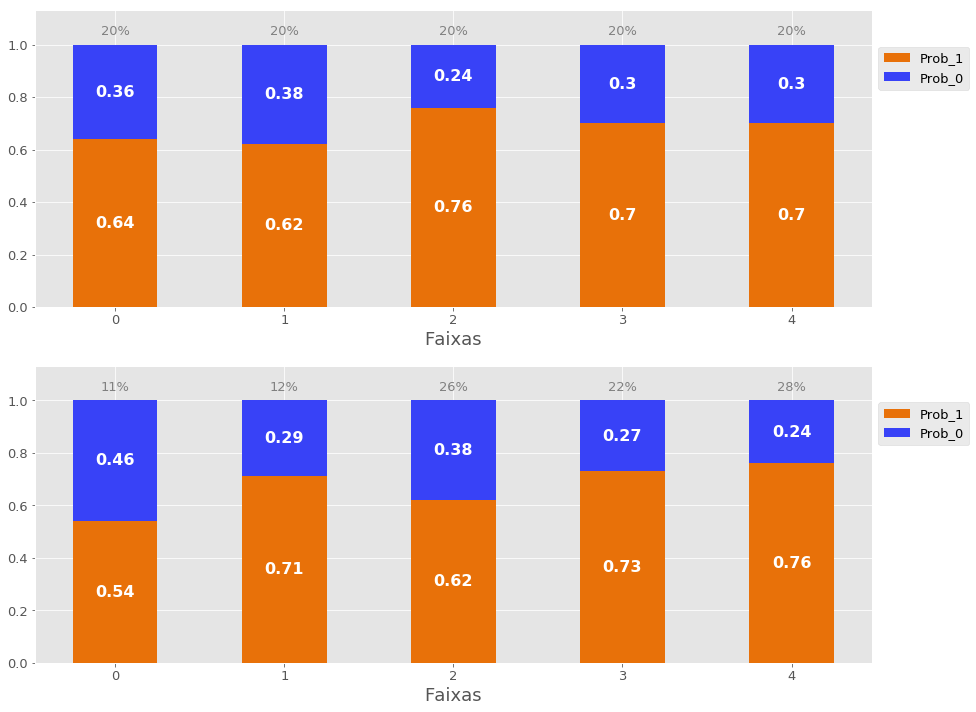

In [226]:
plots_prob_groups (train_table, test_table)